# Person Re-ID on Market-1501 (Ranking)

This is for generating a ranked list of images given a trained model and a query image.

First, import required modules. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../' # Expected to be in rank_scripts/

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

In [16]:
#getDiff Implementation
def getDiff( vector1, vector2 ):
    sum=0
    
    for j in range(4096):
        diff= vector1[j]-vector2[j]
        diff=diff*diff
        sum=sum+diff
        
    return math.sqrt(sum)

In [32]:
caffe.set_device(0)
caffe.set_mode_gpu()
net = caffe.Net(caffe_root +  'rank_scripts/rank_alexnet/my_unsup_net_deploy.prototxt',
                caffe_root + 'rank_scripts/models14/_iter_1000.caffemodel',
                caffe.TEST)# input preprocessing: 'data'is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'rank_scripts/query_128x128_market.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [33]:
# set net to batch size
net.blobs['data'].reshape(50,3,128,128)

[ 0.92726064  0.62224072  0.95433229 ...,  1.36914277  0.80687553
  0.95740831]


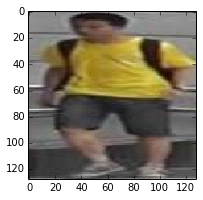

In [35]:
query_image_path = 'rank_scripts/images_market/0042_c3s3_064169_01.jpg'
query_image = caffe.io.load_image(caffe_root + query_image_path)
net.blobs['data'].data[...] = transformer.preprocess('data', query_image)
out = net.forward()
vector_query = out['fc7'][0]
plt.figure(figsize=(3,3))
plt.imshow(query_image)
print vector_query

[ 0.92200375  0.62041491  0.95242971 ...,  1.35197806  0.82136965
  0.96460617]


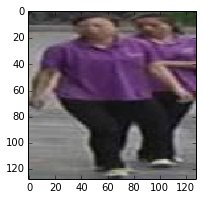

In [24]:
query_image_path = 'rank_scripts/images_market/0026_c2s1_001626_00.jpg'
query_image = caffe.io.load_image(caffe_root + query_image_path)
net.blobs['data'].data[...] = transformer.preprocess('data', query_image)
out = net.forward()
vector_query = out['fc7'][0]
plt.figure(figsize=(3,3))
plt.imshow(query_image)
print vector_query

In [36]:
#Rank Vector Setup
num_rank = 6

In [37]:
#Paired list to hold (diff,imagePath)

Rank_list= []
query_folder = caffe_root + 'rank_scripts/images_market/'
images_list = os.listdir(query_folder)
i=10

#print images_list

for image in images_list:
    new_net = caffe.Net(caffe_root +  'rank_scripts/rank_alexnet/my_unsup_net_deploy.prototxt',
                caffe_root + 'rank_scripts/models14/_iter_1000.caffemodel',
                caffe.TEST)
        
    new_net.blobs['data'].reshape(50,3,128,128)
    new_net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(query_folder + image))
    output=new_net.forward()
    vector_new=output['fc7'][0]
    diff = getDiff(vector_query, vector_new)
    
    #add the pair (diff,image) to the list
    Rank_list.append((diff,image))
    
    #sort the list based on diff
    Rank_list.sort()

    #remove the last element if more than 'num_rank'
    if len(Rank_list) > num_rank :
        Rank_list.remove(Rank_list[len(Rank_list)-1])
    
print Rank_list

[(0.0, '0042_c3s3_064169_01.jpg'), (0.19826740133238682, '0042_c3s3_064144_04.jpg'), (0.3058049011554784, '0042_c2s3_057927_04.jpg'), (0.3134898393012393, '0042_c6s3_087892_02.jpg'), (0.32679195877762646, '0155_c1s1_025651_00.jpg'), (0.32850636727552074, '0146_c5s1_023626_00.jpg')]


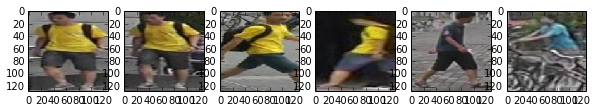

In [38]:
fig,axs = plt.subplots (nrows=1,ncols=len(Rank_list))
i=0

for item in Rank_list:
    new_image_name = item[1]
    new_image = caffe.io.load_image(query_folder + new_image_name)
    
    plt.figure(figsize=(3,3))
    axs[i].imshow(new_image)
    i=i+1